In [1]:
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from typing import Optional, Tuple, Union
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Dict

2026-01-19 10:55:25.436624: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 10:55:26.107138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768820126.328865    6504 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768820126.392983    6504 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-19 10:55:26.968914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:

metadata_path = Path("../data/final_dataset_noaug2/metadata.csv")
metadata_noaug_path = Path("../data/final_dataset/metadata.csv")
df = pd.read_csv(metadata_path)
df_noaug = pd.read_csv(metadata_noaug_path)

print(df.columns)
print(df.iloc[1])


Index(['image_path', 'label', 'caption'], dtype='object')
image_path                                     new_ball_196.jpg
label                                                Label.BALL
caption       In the sun-drenched backyard, a joyful black a...
Name: 1, dtype: object


### UTILS

In [4]:
def get_label(filename: str):
    return filename.split("_")[0]

def get_uuid(filename: str):
    name = Path(filename).stem
    parts = name.split("_")
    return "_".join(parts[:2])

def build_augmented_path(img_path: Path, base_dir: Path):
    img_path = Path(img_path)
    filename = img_path.name
    label = get_label(filename)
    uuid = get_uuid(filename)
    uuid_dir = "_".join(filename.split(".")[0].split("_")[1:])


    return base_dir  / uuid / uuid_dir / filename

### CLIP DATASET BASE MODEL

In [5]:
from typing import Tuple
class CLIPDataset(Dataset):
    """
    Dataset unifié pour CLIP supportant:
    - Images avec transforms (Visual Classifier)
    - Tokenization Keras (SmallBERT)
    - Tokenization HuggingFace (DistilBERT)
    
    Args:
        df: DataFrame avec colonnes 'image_path', 'label', 'caption'
        base_dir: Répertoire de base pour les images
        transform: Transformations d'image (torchvision)
        keras_tokenizer: Tokenizer Keras (optionnel, pour SmallBERT)
        hf_tokenizer: Tokenizer HuggingFace (optionnel, pour DistilBERT)
        max_seq_len: Longueur max des séquences
        vocab_size: Taille du vocabulaire pour Keras tokenizer
        text_mode: 'keras', 'hf', ou 'both' pour le type de tokenization
    """
    
    def __init__(
        self,
        df,
        base_dir: Path,
        transform,
        keras_tokenizer=None,
        hf_tokenizer=None,
        max_seq_len: int = 64,
        vocab_size: int = 1000,
        text_mode: str = "keras"  # 'keras', 'hf', ou 'both'
    ):
        self.base_dir = Path(base_dir)
        self.transform = transform
        self.max_seq_len = max_seq_len
        self.vocab_size = 1000
        self.text_mode = text_mode
        
        # Données du DataFrame
        self.img_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()
        self.captions = df["caption"].tolist()
        
        # Mapping des classes
        self.classes = sorted(set(self.labels))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.num_classes = len(self.classes)
        
        # Tokenizers
        self.keras_tokenizer = keras_tokenizer
        self.hf_tokenizer = hf_tokenizer
        
        # Setup OOV pour Keras
        if self.keras_tokenizer is not None:
            oov_tok = getattr(self.keras_tokenizer, "oov_token", "<OOV>")
            self.oov_id = self.keras_tokenizer.word_index.get(oov_tok, 1)
            if self.oov_id is None or self.oov_id >= self.vocab_size:
                self.oov_id = 1
        
        # Validation
        self._validate_tokenizers()
    
    def _validate_tokenizers(self):
        """Valide que les tokenizers nécessaires sont fournis"""
        if self.text_mode in ["keras", "both"] and self.keras_tokenizer is None:
            raise ValueError("keras_tokenizer requis pour text_mode='keras' ou 'both'")
        if self.text_mode in ["hf", "both"] and self.hf_tokenizer is None:
            raise ValueError("hf_tokenizer requis pour text_mode='hf' ou 'both'")
    
    def _build_image_path(self, img_path: str) -> Path:
        """Construit le chemin complet de l'image"""
        return Path(build_augmented_path(img_path, self.base_dir))
    
    def _tokenize_keras(self, text: str) -> torch.Tensor:
        """Tokenization style SmallBERT (Keras)"""
        seq = self.keras_tokenizer.texts_to_sequences([text])[0]
        # Remplace les tokens hors vocab par OOV
        seq = [
            t if (t is not None and 0 <= t < self.vocab_size) else self.oov_id
            for t in seq
        ]
        # Padding
        padded = pad_sequences(
            [seq],
            maxlen=self.max_seq_len,
            padding="post",
            truncating="post",
            value=0
        )[0].astype(np.int64)
        
        return torch.tensor(padded, dtype=torch.long)
    
    def _tokenize_hf(self, text: str) -> dict:
        """Tokenization style DistilBERT (HuggingFace)"""
        enc = self.hf_tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_seq_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0).to(torch.long),
            "attention_mask": enc["attention_mask"].squeeze(0).to(torch.long)
        }
    
    def __getitem__(self, idx: int) -> dict:
        # === IMAGE ===
        img_path = self._build_image_path(self.img_paths[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        # === CAPTION ===
        caption = str(self.captions[idx])
        
        # === LABEL ===
        label_str = self.labels[idx]
        label = torch.tensor(self.class_to_idx[label_str], dtype=torch.long)
        
        # === OUTPUT DICT ===
        output = {
            "idx": torch.tensor(idx, dtype=torch.long),
            "image": img,
            "label": label,
            "caption": caption,
        }
        
        # Tokenization selon le mode
        if self.text_mode in ["keras", "both"]:
            input_ids_keras = self._tokenize_keras(caption)
            output["input_ids_keras"] = input_ids_keras
            output["attention_mask_keras"] = (input_ids_keras != 0).long()
            
            # Pour compatibilité avec l'ancien format
            if self.text_mode == "keras":
                output["input_ids"] = input_ids_keras
                output["attention_mask"] = output["attention_mask_keras"]
        
        if self.text_mode in ["hf", "both"]:
            hf_tokens = self._tokenize_hf(caption)
            output["input_ids_hf"] = hf_tokens["input_ids"]
            output["attention_mask_hf"] = hf_tokens["attention_mask"]
            
            # Pour compatibilité avec l'ancien format
            if self.text_mode == "hf":
                output["input_ids"] = hf_tokens["input_ids"]
                output["attention_mask"] = hf_tokens["attention_mask"]
        
        return output
    
    def __len__(self) -> int:
        return len(self.img_paths)
    
    # === Méthodes utilitaires (compatibilité ImageCLIPDataset) ===
    
    def _get_img_path_from_idx(self, idx: int) -> Path:
        return self._build_image_path(self.img_paths[idx])
    
    def _get_caption_from_idx(self, idx: int) -> str:
        return self.captions[idx]
    
    def _get_label_from_idx(self, idx: int) -> str:
        return self.labels[idx]
    
    def _get_img_size(self, idx: int) -> Tuple[int, int]:
        img_path = self._build_image_path(self.img_paths[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            for t in self.transform.transforms:
                if isinstance(t, transforms.Resize):
                    img = t(img)
        return img.height, img.width

In [6]:
from transformers import DistilBertTokenizer

# === Chargement des données ===
metadata_path = Path("../data/final_dataset_noaug/metadata.csv")
base_dir = Path("../data/final_dataset_noaug")
df = pd.read_csv(metadata_path)

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# === Tokenizers ===
# Keras tokenizer pour SmallBERT
keras_tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(df["caption"])

# HuggingFace tokenizer pour DistilBERT
hf_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# === Dataset unifié ===
# Mode 'keras' pour SmallBERT
dataset_smallbert = CLIPDataset(
    df=df,
    base_dir=base_dir,
    transform=transform,
    keras_tokenizer=keras_tokenizer,
    max_seq_len=64,
    vocab_size=5000,
    text_mode="keras"
)

# Mode 'hf' pour DistilBERT
dataset_distilbert = CLIPDataset(
    df=df,
    base_dir=base_dir,
    transform=transform,
    hf_tokenizer=hf_tokenizer,
    max_seq_len=64,
    text_mode="hf"
)

# Mode 'both' pour avoir les deux tokenizations
dataset_both = CLIPDataset(
    df=df,
    base_dir=base_dir,
    transform=transform,
    keras_tokenizer=keras_tokenizer,
    hf_tokenizer=hf_tokenizer,
    max_seq_len=64,
    vocab_size=5000,
    text_mode="both"
)

# === DataLoader ===
train_loader = DataLoader(dataset_both, batch_size=32, shuffle=True)

batch = next(iter(train_loader))
print("Keys:", batch.keys())
print("Image shape:", batch["image"].shape)
print("Label shape:", batch["label"].shape)
print("input_ids_keras shape:", batch["input_ids_keras"].shape)
print("input_ids_hf shape:", batch["input_ids_hf"].shape)
print(batch["caption"])

/home/ubuntu/MiniCLIP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Keys: dict_keys(['idx', 'image', 'label', 'caption', 'input_ids_keras', 'attention_mask_keras', 'input_ids_hf', 'attention_mask_hf'])
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])
input_ids_keras shape: torch.Size([32, 64])
input_ids_hf shape: torch.Size([32, 64])
['A woman, likely on her daily commute, pedals steadily along a winding path through a lush park, surrounded by a group of energetic dogs running playfully alongside her as she navigates the bike. The sun casts dappled shadows across the grass beneath their feet, and the sound of laughter carries through the air as they enjoy this pleasant morning outing together. In the background, trees sway gently in the breeze, adding to the serene atmosphere of this idyllic scene.', "A playful black dog is frolicking in the warm sunlight, its joyful energy infectious as it chases after a bright green rubber toy across the lush yellow grass of a serene backyard. The air is filled with the sweet scent of blooming

### VISION ENCODER

In [17]:
# =============================================================================
# IMAGE ENCODER (CNNBasic pour CLIP)
# =============================================================================

class CNNBasicEncoder(nn.Module):
    """
    CNNBasic adapté pour CLIP - retourne des embeddings de dimension projection_dim
    """
    def __init__(self, projection_dim: int = 256, input_size: Tuple[int, int] = (224, 224)):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
        )
        
        # Dropout sur feature maps
        self.dropout = nn.Dropout2d(p=0.2)
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Projection vers l'espace commun CLIP
        self.projection = nn.Sequential(
            nn.Linear(256, projection_dim),
            nn.LayerNorm(projection_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, 3, H, W) images
        Returns:
            embeddings: (B, projection_dim) normalized image embeddings
        """
        x = self.features(x)
        x = self.dropout(x)
        x = self.gap(x).flatten(1)  # (B, 256)
        
        # Projection + L2 normalization
        embeddings = self.projection(x)
        embeddings = F.normalize(embeddings, p=2, dim=-1)
        
        return embeddings

### RESNET ENCODER

In [8]:
# =============================================================================
# IMAGE ENCODER (ResNet18 pour CLIP) - avec fine-tuning partiel
# =============================================================================

from torchvision.models import resnet18, ResNet18_Weights

class ResNet18Encoder(nn.Module):
    """
    ResNet18 adapté pour CLIP - retourne des embeddings de dimension projection_dim
    Utilise les poids pré-entraînés ImageNet
    """
    def __init__(self, projection_dim: int = 256, freeze_mode: str = "none"):
        """
        Args:
            projection_dim: Dimension de l'embedding de sortie
            freeze_mode: 
                - "none": Entraîne tout
                - "all": Gèle tout le backbone
                - "except_layer4": Gèle tout sauf layer4 (recommandé)
                - "except_layer3_4": Gèle tout sauf layer3 et layer4
        """
        super().__init__()
        
        # Charger ResNet18 avec poids pré-entraînés
        weights = ResNet18_Weights.IMAGENET1K_V1
        resnet = resnet18(weights=weights)
        
        # Séparer les couches pour contrôle fin
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # Dimension de sortie de ResNet18 = 512
        self.feature_dim = 512
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Projection vers l'espace commun CLIP
        self.projection = nn.Sequential(
            nn.Linear(self.feature_dim, projection_dim),
            nn.LayerNorm(projection_dim)
        )
        
        # Appliquer le freeze selon le mode
        self.freeze_mode = freeze_mode
        self._apply_freeze_mode(freeze_mode)
    
    def _apply_freeze_mode(self, mode: str):
        """Applique le mode de gel des poids"""
        if mode == "none":
            # Tout est entraînable
            pass
        elif mode == "all":
            # Gèle tout le backbone
            for name, param in self.named_parameters():
                if "projection" not in name:
                    param.requires_grad = False
        elif mode == "except_layer4":
            # Gèle tout SAUF layer4 et projection
            for param in self.conv1.parameters():
                param.requires_grad = False
            for param in self.bn1.parameters():
                param.requires_grad = False
            for param in self.layer1.parameters():
                param.requires_grad = False
            for param in self.layer2.parameters():
                param.requires_grad = False
            for param in self.layer3.parameters():
                param.requires_grad = False
            # layer4 reste entraînable
            # projection reste entraînable
        elif mode == "except_layer3_4":
            # Gèle tout SAUF layer3, layer4 et projection
            for param in self.conv1.parameters():
                param.requires_grad = False
            for param in self.bn1.parameters():
                param.requires_grad = False
            for param in self.layer1.parameters():
                param.requires_grad = False
            for param in self.layer2.parameters():
                param.requires_grad = False
            # layer3 reste entraînable
            # layer4 reste entraînable
        else:
            raise ValueError(f"freeze_mode inconnu: {mode}")
    
    def unfreeze_all(self):
        """Dégèle tous les poids"""
        for param in self.parameters():
            param.requires_grad = True
    
    def get_trainable_params_info(self):
        """Affiche les infos sur les paramètres entraînables"""
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"ResNet18Encoder - freeze_mode='{self.freeze_mode}'")
        print(f"  Total params: {total:,}")
        print(f"  Trainable: {trainable:,} ({100*trainable/total:.1f}%)")
        print(f"  Frozen: {total-trainable:,} ({100*(total-trainable)/total:.1f}%)")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x).flatten(1)
        
        embeddings = self.projection(x)
        embeddings = F.normalize(embeddings, p=2, dim=-1)
        
        return embeddings

### TEXT ENCODER

In [9]:
# =============================================================================
# BLOCS DE BASE (à mettre dans une cellule)
# =============================================================================

class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_embeddings = nn.Embedding(sequence_length, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        return self.token_embeddings(x) + self.position_embeddings(positions)


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout_rate: float = 0.1):
        super().__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor = None) -> torch.Tensor:
        attn_output, _ = self.att(x, x, x, key_padding_mask=padding_mask)
        x = self.layernorm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        return self.layernorm2(x + self.dropout2(ffn_output))

In [10]:
# =============================================================================
# TEXT ENCODER (SmallBERT pour CLIP)
# =============================================================================

class SmallBERTEncoder(nn.Module):
    """
    SmallBERT adapté pour CLIP - retourne des embeddings de dimension projection_dim
    """
    def __init__(
        self,
        sequence_length: int,
        vocab_size: int,
        embed_dim: int = 256,
        num_heads: int = 4,
        ff_dim: int = 512,
        num_layers: int = 2,
        projection_dim: int = 256
    ):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.layernorm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.3)
        
        # Attention pooling pour agréger les tokens
        self.pooler = nn.Linear(embed_dim, 1)
        
        # Projection vers l'espace commun CLIP
        self.projection = nn.Sequential(
            nn.Linear(embed_dim, projection_dim),
            nn.LayerNorm(projection_dim)
        )

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Args:
            input_ids: (B, T) token ids, 0 = PAD
        Returns:
            embeddings: (B, projection_dim) normalized text embeddings
        """
        padding_mask = (input_ids == 0)
        x = self.pos_embedding(input_ids)

        for block in self.blocks:
            x = block(x, padding_mask=padding_mask)

        x = self.layernorm(x)  # (B, T, embed_dim)
        x = self.dropout(x)
        
        # Attention pooling
        scores = self.pooler(x).squeeze(-1)  # (B, T)
        scores = scores.masked_fill(padding_mask, float("-inf"))
        weights = torch.softmax(scores, dim=1)  # (B, T)
        pooled = torch.sum(x * weights.unsqueeze(-1), dim=1)  # (B, embed_dim)
        
        # Projection + L2 normalization
        embeddings = self.projection(pooled)
        embeddings = F.normalize(embeddings, p=2, dim=-1)
        
        return embeddings

### CONTRASTIVE LOSS

In [11]:
# =============================================================================
# CLIP LOSS (InfoNCE / Contrastive Loss)
# =============================================================================

class CLIPLoss(nn.Module):
    """
    Contrastive loss pour CLIP (InfoNCE symétrique)
    """
    def __init__(self, temperature: float = 0.07):
        super().__init__()
        self.temperature = nn.Parameter(torch.tensor(temperature))
        
    def forward(
        self, 
        image_embeddings: torch.Tensor, 
        text_embeddings: torch.Tensor
    ) -> torch.Tensor:
        """
        Args:
            image_embeddings: (B, D) normalized image embeddings
            text_embeddings: (B, D) normalized text embeddings
        Returns:
            loss: scalar contrastive loss
        """
        # Calcul de la similarité cosinus (les embeddings sont déjà normalisés)
        # logits[i, j] = similarité entre image_i et text_j
        logits = (image_embeddings @ text_embeddings.T) / self.temperature  # (B, B)
        
        # Labels: la diagonale (image_i correspond à text_i)
        batch_size = image_embeddings.size(0)
        labels = torch.arange(batch_size, device=logits.device)
        
        # Cross-entropy symétrique
        loss_i2t = F.cross_entropy(logits, labels)      # image -> text
        loss_t2i = F.cross_entropy(logits.T, labels)    # text -> image
        
        loss = (loss_i2t + loss_t2i) / 2.0
        return loss

### MINI CONTRASTIVE MODEL


In [12]:
# =============================================================================
# MODÈLE CLIP COMPLET
# =============================================================================

class MiniCLIP(nn.Module):
    """
    Mini-CLIP: Modèle contrastif image-texte
    Combine CNNBasic (vision) et SmallBERT (texte)
    """
    def __init__(
        self,
        # Text encoder params
        sequence_length: int = 64,
        vocab_size: int = 5000,
        text_embed_dim: int = 256,
        text_num_heads: int = 4,
        text_ff_dim: int = 512,
        text_num_layers: int = 2,
        # Shared params
        projection_dim: int = 256,
        temperature: float = 0.07
    ):
        super().__init__()
        
        # Encodeurs
        self.image_encoder = CNNBasicEncoder(projection_dim=projection_dim)
        self.text_encoder = SmallBERTEncoder(
            sequence_length=sequence_length,
            vocab_size=vocab_size,
            embed_dim=text_embed_dim,
            num_heads=text_num_heads,
            ff_dim=text_ff_dim,
            num_layers=text_num_layers,
            projection_dim=projection_dim
        )
        
        # Loss
        self.clip_loss = CLIPLoss(temperature=temperature)
        
        # Paramètre de température (learnable)
        self.logit_scale = nn.Parameter(torch.log(torch.tensor(1.0 / temperature)))

    def encode_image(self, images: torch.Tensor) -> torch.Tensor:
        """Encode images en embeddings normalisés"""
        return self.image_encoder(images)
    
    def encode_text(self, input_ids: torch.Tensor) -> torch.Tensor:
        """Encode texte en embeddings normalisés"""
        return self.text_encoder(input_ids)
    
    def forward(
        self, 
        images: torch.Tensor, 
        input_ids: torch.Tensor
    ) -> Dict[str, torch.Tensor]:
        """
        Forward pass complet
        
        Args:
            images: (B, 3, H, W)
            input_ids: (B, T)
            
        Returns:
            dict avec 'loss', 'image_embeddings', 'text_embeddings', 'logits'
        """
        # Encode
        image_embeddings = self.encode_image(images)
        text_embeddings = self.encode_text(input_ids)
        
        # Compute similarity matrix
        logit_scale = self.logit_scale.exp().clamp(max=100)
        logits = logit_scale * (image_embeddings @ text_embeddings.T)
        
        # Loss
        loss = self.clip_loss(image_embeddings, text_embeddings)
        
        return {
            "loss": loss,
            "image_embeddings": image_embeddings,
            "text_embeddings": text_embeddings,
            "logits": logits,
            "logit_scale": logit_scale
        }
    
    def get_similarity(
        self, 
        images: torch.Tensor, 
        input_ids: torch.Tensor
    ) -> torch.Tensor:
        """Calcule la matrice de similarité image-texte"""
        image_emb = self.encode_image(images)
        text_emb = self.encode_text(input_ids)
        logit_scale = self.logit_scale.exp().clamp(max=100)
        return logit_scale * (image_emb @ text_emb.T)

### MINI CONTRASTIVE MODEL WITH RESNET

In [13]:
class MiniCLIPResnet(nn.Module):
    def __init__(
        self,
        sequence_length: int = 64,
        vocab_size: int = 5000,
        text_embed_dim: int = 256,
        text_num_heads: int = 4,
        text_ff_dim: int = 512,
        text_num_layers: int = 2,
        projection_dim: int = 256,
        temperature: float = 0.07,
        freeze_mode: str = "except_layer4"  # ← Nouveau paramètre
    ):
        super().__init__()
        
        # Encodeur d'images avec freeze_mode
        self.image_encoder = ResNet18Encoder(
            projection_dim=projection_dim,
            freeze_mode=freeze_mode
        )
        
        # Encodeur de texte
        self.text_encoder = SmallBERTEncoder(
            sequence_length=sequence_length,
            vocab_size=vocab_size,
            embed_dim=text_embed_dim,
            num_heads=text_num_heads,
            ff_dim=text_ff_dim,
            num_layers=text_num_layers,
            projection_dim=projection_dim
        )
        
        self.clip_loss = CLIPLoss(temperature=temperature)
        self.logit_scale = nn.Parameter(torch.log(torch.tensor(1.0 / temperature)))

    def encode_image(self, images: torch.Tensor) -> torch.Tensor:
        return self.image_encoder(images)
    
    def encode_text(self, input_ids: torch.Tensor) -> torch.Tensor:
        return self.text_encoder(input_ids)
    
    def forward(self, images: torch.Tensor, input_ids: torch.Tensor) -> Dict[str, torch.Tensor]:
        image_embeddings = self.encode_image(images)
        text_embeddings = self.encode_text(input_ids)
        
        logit_scale = self.logit_scale.exp().clamp(max=100)
        logits = logit_scale * (image_embeddings @ text_embeddings.T)
        loss = self.clip_loss(image_embeddings, text_embeddings)
        
        return {
            "loss": loss,
            "image_embeddings": image_embeddings,
            "text_embeddings": text_embeddings,
            "logits": logits,
            "logit_scale": logit_scale
        }
    
    def get_similarity(self, images: torch.Tensor, input_ids: torch.Tensor) -> torch.Tensor:
        image_emb = self.encode_image(images)
        text_emb = self.encode_text(input_ids)
        logit_scale = self.logit_scale.exp().clamp(max=100)
        return logit_scale * (image_emb @ text_emb.T)

### TRAIN METHOD

In [14]:
# =============================================================================
# FONCTIONS D'ENTRAÎNEMENT
# =============================================================================

from tqdm import tqdm

def train_one_epoch_clip(
    model: MiniCLIP,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    epochs: int
) -> float:
    """Entraîne le modèle CLIP pour une époque"""
    model.train()
    running_loss = 0.0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs} [TRAIN]")
    for batch in loop:
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)  # utilise input_ids_keras si mode keras

        optimizer.zero_grad(set_to_none=True)
        
        outputs = model(images, input_ids)
        loss = outputs["loss"]
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(
            loss=running_loss / (loop.n + 1),
            temp=outputs["logit_scale"].item()
        )

    return running_loss / len(loader)


@torch.no_grad()
def evaluate_clip(
    model: MiniCLIP,
    loader: DataLoader,
    device: torch.device,
    epoch: int,
    epochs: int
) -> Dict[str, float]:
    """Évalue le modèle CLIP"""
    model.eval()
    running_loss = 0.0
    
    all_image_emb = []
    all_text_emb = []
    all_labels = []

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs} [EVAL]")
    for batch in loop:
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"]

        outputs = model(images, input_ids)
        running_loss += outputs["loss"].item()
        
        all_image_emb.append(outputs["image_embeddings"].cpu())
        all_text_emb.append(outputs["text_embeddings"].cpu())
        all_labels.append(labels)

    avg_loss = running_loss / len(loader)
    
    # Calcul des métriques de retrieval
    all_image_emb = torch.cat(all_image_emb)
    all_text_emb = torch.cat(all_text_emb)
    all_labels = torch.cat(all_labels)
    
    # Image-to-Text Retrieval (R@1, R@5)
    similarity = all_image_emb @ all_text_emb.T
    i2t_ranks = (similarity.argsort(dim=1, descending=True) == torch.arange(len(similarity)).unsqueeze(1)).float().argmax(dim=1)
    i2t_r1 = (i2t_ranks < 1).float().mean().item()
    i2t_r5 = (i2t_ranks < 5).float().mean().item()
    
    # Text-to-Image Retrieval
    t2i_ranks = (similarity.T.argsort(dim=1, descending=True) == torch.arange(len(similarity)).unsqueeze(1)).float().argmax(dim=1)
    t2i_r1 = (t2i_ranks < 1).float().mean().item()
    t2i_r5 = (t2i_ranks < 5).float().mean().item()
    
    return {
        "loss": avg_loss,
        "i2t_r1": i2t_r1,
        "i2t_r5": i2t_r5,
        "t2i_r1": t2i_r1,
        "t2i_r5": t2i_r5,
        "mean_r1": (i2t_r1 + t2i_r1) / 2
    }

In [25]:
# =============================================================================
# EXEMPLE D'UTILISATION
# =============================================================================

# === Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# === Données ===
metadata_path = Path("../data/final_dataset_noaug/metadata.csv")
base_dir = Path("../data/final_dataset_noaug")
df = pd.read_csv(metadata_path)

# Split train/val/test
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=11, stratify=df["label"])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=11, stratify=df_temp["label"])

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_base = transforms.Compose(
    [transforms.Resize((300, 500)),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# === Tokenizer Keras ===
vocab_size = 5000
seq_len = 64
keras_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(df["caption"])
actual_vocab_size = min(len(keras_tokenizer.word_index) + 1, vocab_size)

# === Datasets ===
train_dataset = CLIPDataset(
    df=df_train, base_dir=base_dir, transform=transform_base,
    keras_tokenizer=keras_tokenizer, max_seq_len=seq_len,
    vocab_size=vocab_size, text_mode="keras"
)
val_dataset = CLIPDataset(
    df=df_val, base_dir=base_dir, transform=transform_base,
    keras_tokenizer=keras_tokenizer, max_seq_len=seq_len,
    vocab_size=vocab_size, text_mode="keras"
)

# === DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# # === Modèle ===
# model = MiniCLIP(
#     sequence_length=seq_len,
#     vocab_size=actual_vocab_size,
#     text_embed_dim=256,
#     text_num_heads=4,
#     text_ff_dim=512,
#     text_num_layers=2,
#     projection_dim=256,
#     temperature=0.07
# ).to(device)

# # model = MiniCLIPResnet(
# #     sequence_length=seq_len,
# #     vocab_size=actual_vocab_size,
# #     text_embed_dim=256,
# #     text_num_heads=4,
# #     text_ff_dim=512,
# #     text_num_layers=2,
# #     projection_dim=256,
# #     temperature=0.07,
# #     freeze_backbone=False,          # True pour fine-tuning léger, False pour entraîner tout
# #     image_encoder_type="resnet18"   # Utilise ResNet18 au lieu de CNNBasic
# # ).to(device)

# # print(f"Paramètres totaux: {sum(p.numel() for p in model.parameters()):,}")
# # print(f"Paramètres entraînables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# # print(f"Paramètres: {sum(p.numel() for p in model.parameters()):,}")

# # # === Optimizer ===
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
# # # Learning rates différenciés
# # backbone_params = list(model.image_encoder.backbone.parameters())
# # other_params = [p for n, p in model.named_parameters() 
# #                 if 'image_encoder.backbone' not in n]

# # optimizer = torch.optim.AdamW([
# #     {'params': backbone_params, 'lr': 1e-5},    # LR faible pour backbone pré-entraîné
# #     {'params': other_params, 'lr': 3e-4}         # LR normal pour le reste
# # ], weight_decay=0.01)

# # model = MiniCLIPResnet(
# #     sequence_length=seq_len,
# #     vocab_size=actual_vocab_size,
# #     text_embed_dim=256,
# #     text_num_heads=4,
# #     text_ff_dim=512,
# #     text_num_layers=2,
# #     projection_dim=256,
# #     temperature=0.07,
# #     freeze_mode="except_layer4"  # ← Seuls layer4 + projection sont entraînés
# # ).to(device)

# # # Afficher les infos
# # model.image_encoder.get_trainable_params_info()

# # print(f"\nModèle complet:")
# # print(f"  Paramètres totaux: {sum(p.numel() for p in model.parameters()):,}")
# # print(f"  Paramètres entraînables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# # # === Optimizer simple (pas besoin de LR différenciés) ===
# # optimizer = torch.optim.AdamW(
# #     filter(lambda p: p.requires_grad, model.parameters()),  # Seulement les params entraînables
# #     lr=1e-4, 
# #     weight_decay=0.01
# # )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
# === Modèle amélioré ===
model = MiniCLIPResnet(
    sequence_length=seq_len,
    vocab_size=actual_vocab_size,
    text_embed_dim=384,
    text_num_heads=6,
    text_ff_dim=768,
    text_num_layers=3,
    projection_dim=384,
    temperature=0.05,
    freeze_mode="except_layer3_4" 
).to(device)

model.image_encoder.get_trainable_params_info()

# === Optimizer avec LR plus agressif ===
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-4,
    weight_decay=0.02
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=2
)
# === Training Loop ===
epochs = 20
best_loss = float("inf")
history = {"train_loss": [], "val_loss": [], "val_r1": []}
patience = 5
no_improve = 0

for epoch in range(epochs):
    train_loss = train_one_epoch_clip(model, train_loader, optimizer, device, epoch, epochs)
    val_metrics = evaluate_clip(model, val_loader, device, epoch, epochs)
    
    # Early stopping
    if val_metrics["loss"] < best_loss:
        best_loss = val_metrics["loss"]
        torch.save(model.state_dict(), "../models/best_miniclip.pth")
        no_improve = 0
        print("  ✓ Saved best model")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"  ⚠ Early stopping at epoch {epoch+1}")
            break
    
    scheduler.step()
    
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_metrics["loss"])
    history["val_r1"].append(val_metrics["mean_r1"])
    
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_metrics['loss']:.4f}")
    print(f"  I2T R@1: {val_metrics['i2t_r1']*100:.1f}% | R@5: {val_metrics['i2t_r5']*100:.1f}%")
    print(f"  T2I R@1: {val_metrics['t2i_r1']*100:.1f}% | R@5: {val_metrics['t2i_r5']*100:.1f}%")
    
    # Save best model
    if val_metrics["loss"] < best_loss:
        best_loss = val_metrics["loss"]
        torch.save(model.state_dict(), "../models/best_miniclip.pth")
        print("  ✓ Saved best model")

Device: cuda
ResNet18Encoder - freeze_mode='except_layer3_4'
  Total params: 11,374,272
  Trainable: 10,691,200 (94.0%)
  Frozen: 683,072 (6.0%)


Epoch 1/20 [EVAL]: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


  ✓ Saved best model

Epoch 1/20
  Train Loss: 3.3929
  Val Loss: 3.2615
  I2T R@1: 1.7% | R@5: 9.2%
  T2I R@1: 2.5% | R@5: 7.5%


Epoch 2/20 [EVAL]: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


  ✓ Saved best model

Epoch 2/20
  Train Loss: 2.9283
  Val Loss: 2.8873
  I2T R@1: 4.2% | R@5: 21.7%
  T2I R@1: 1.7% | R@5: 13.3%


Epoch 3/20 [EVAL]: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


  ✓ Saved best model

Epoch 3/20
  Train Loss: 2.3978
  Val Loss: 2.8843
  I2T R@1: 6.7% | R@5: 25.0%
  T2I R@1: 5.8% | R@5: 22.5%


Epoch 4/20 [EVAL]: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


  ✓ Saved best model

Epoch 4/20
  Train Loss: 1.8319
  Val Loss: 2.7486
  I2T R@1: 7.5% | R@5: 27.5%
  T2I R@1: 4.2% | R@5: 24.2%


Epoch 5/20 [EVAL]: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]



Epoch 5/20
  Train Loss: 1.3894
  Val Loss: 2.8049
  I2T R@1: 7.5% | R@5: 27.5%
  T2I R@1: 2.5% | R@5: 30.8%


Epoch 6/20 [EVAL]: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]



Epoch 6/20
  Train Loss: 1.3653
  Val Loss: 4.1570
  I2T R@1: 5.8% | R@5: 22.5%
  T2I R@1: 8.3% | R@5: 26.7%


Epoch 7/20 [EVAL]: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]



Epoch 7/20
  Train Loss: 1.6669
  Val Loss: 3.8807
  I2T R@1: 2.5% | R@5: 15.0%
  T2I R@1: 2.5% | R@5: 20.0%


Epoch 8/20 [EVAL]: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]



Epoch 8/20
  Train Loss: 1.5082
  Val Loss: 3.6354
  I2T R@1: 4.2% | R@5: 24.2%
  T2I R@1: 6.7% | R@5: 25.8%


Epoch 9/20 [EVAL]: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]

  ⚠ Early stopping at epoch 9


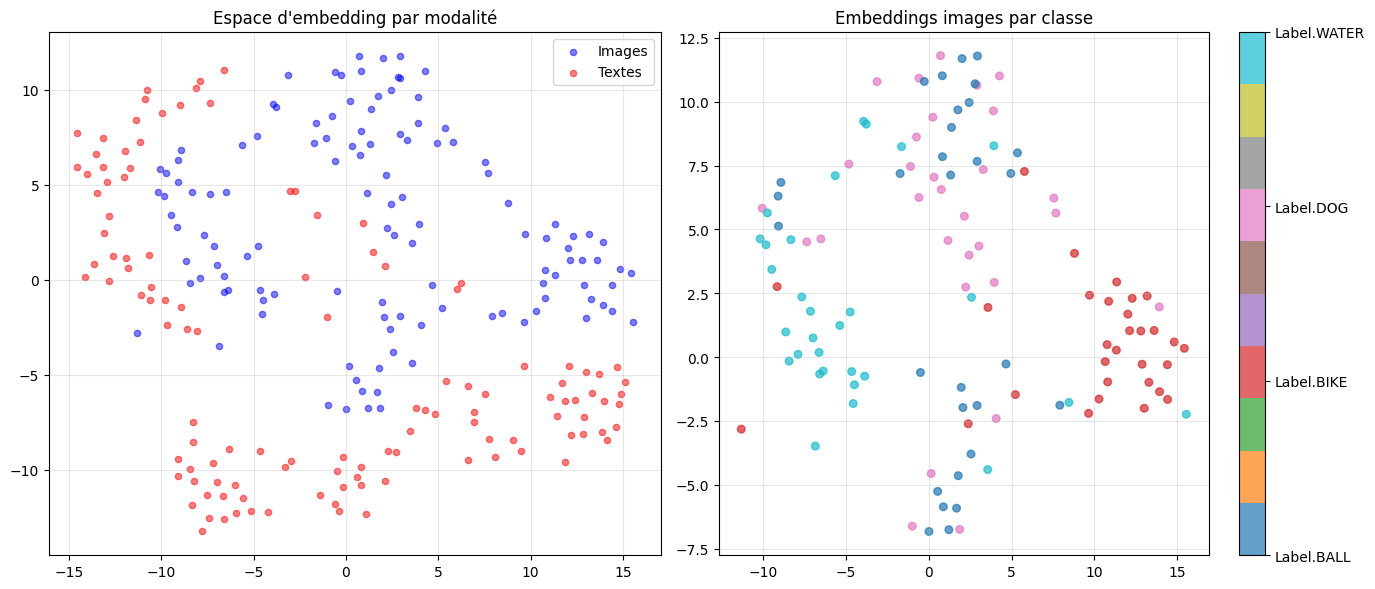

In [26]:
# =============================================================================
# VISUALISATION DE L'ESPACE D'EMBEDDING
# =============================================================================

from sklearn.manifold import TSNE

@torch.no_grad()
def get_all_embeddings(model, loader, device):
    model.eval()
    img_embs, txt_embs, labels, captions = [], [], [], []
    
    for batch in loader:
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        
        img_emb = model.encode_image(images).cpu()
        txt_emb = model.encode_text(input_ids).cpu()
        
        img_embs.append(img_emb)
        txt_embs.append(txt_emb)
        labels.append(batch["label"])
        captions.extend(batch["caption"])
    
    return {
        "image": torch.cat(img_embs).numpy(),
        "text": torch.cat(txt_embs).numpy(),
        "labels": torch.cat(labels).numpy(),
        "captions": captions
    }

# Obtenir les embeddings
embeddings = get_all_embeddings(model, val_loader, device)

# t-SNE sur les embeddings combinés
combined = np.vstack([embeddings["image"], embeddings["text"]])
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(combined)

n = len(embeddings["image"])
img_2d = reduced[:n]
txt_2d = reduced[n:]

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Par modalité
colors_modal = ['blue'] * n + ['red'] * n
axes[0].scatter(reduced[:n, 0], reduced[:n, 1], c='blue', alpha=0.5, label='Images', s=20)
axes[0].scatter(reduced[n:, 0], reduced[n:, 1], c='red', alpha=0.5, label='Textes', s=20)
axes[0].set_title("Espace d'embedding par modalité")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Par classe (images seulement)
class_names = train_dataset.classes
scatter = axes[1].scatter(img_2d[:, 0], img_2d[:, 1], c=embeddings["labels"], 
                          cmap='tab10', alpha=0.7, s=30)
axes[1].set_title("Embeddings images par classe")
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_ticks(range(len(class_names)))
cbar.set_ticklabels(class_names)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### RETRIEVAL RESULTS

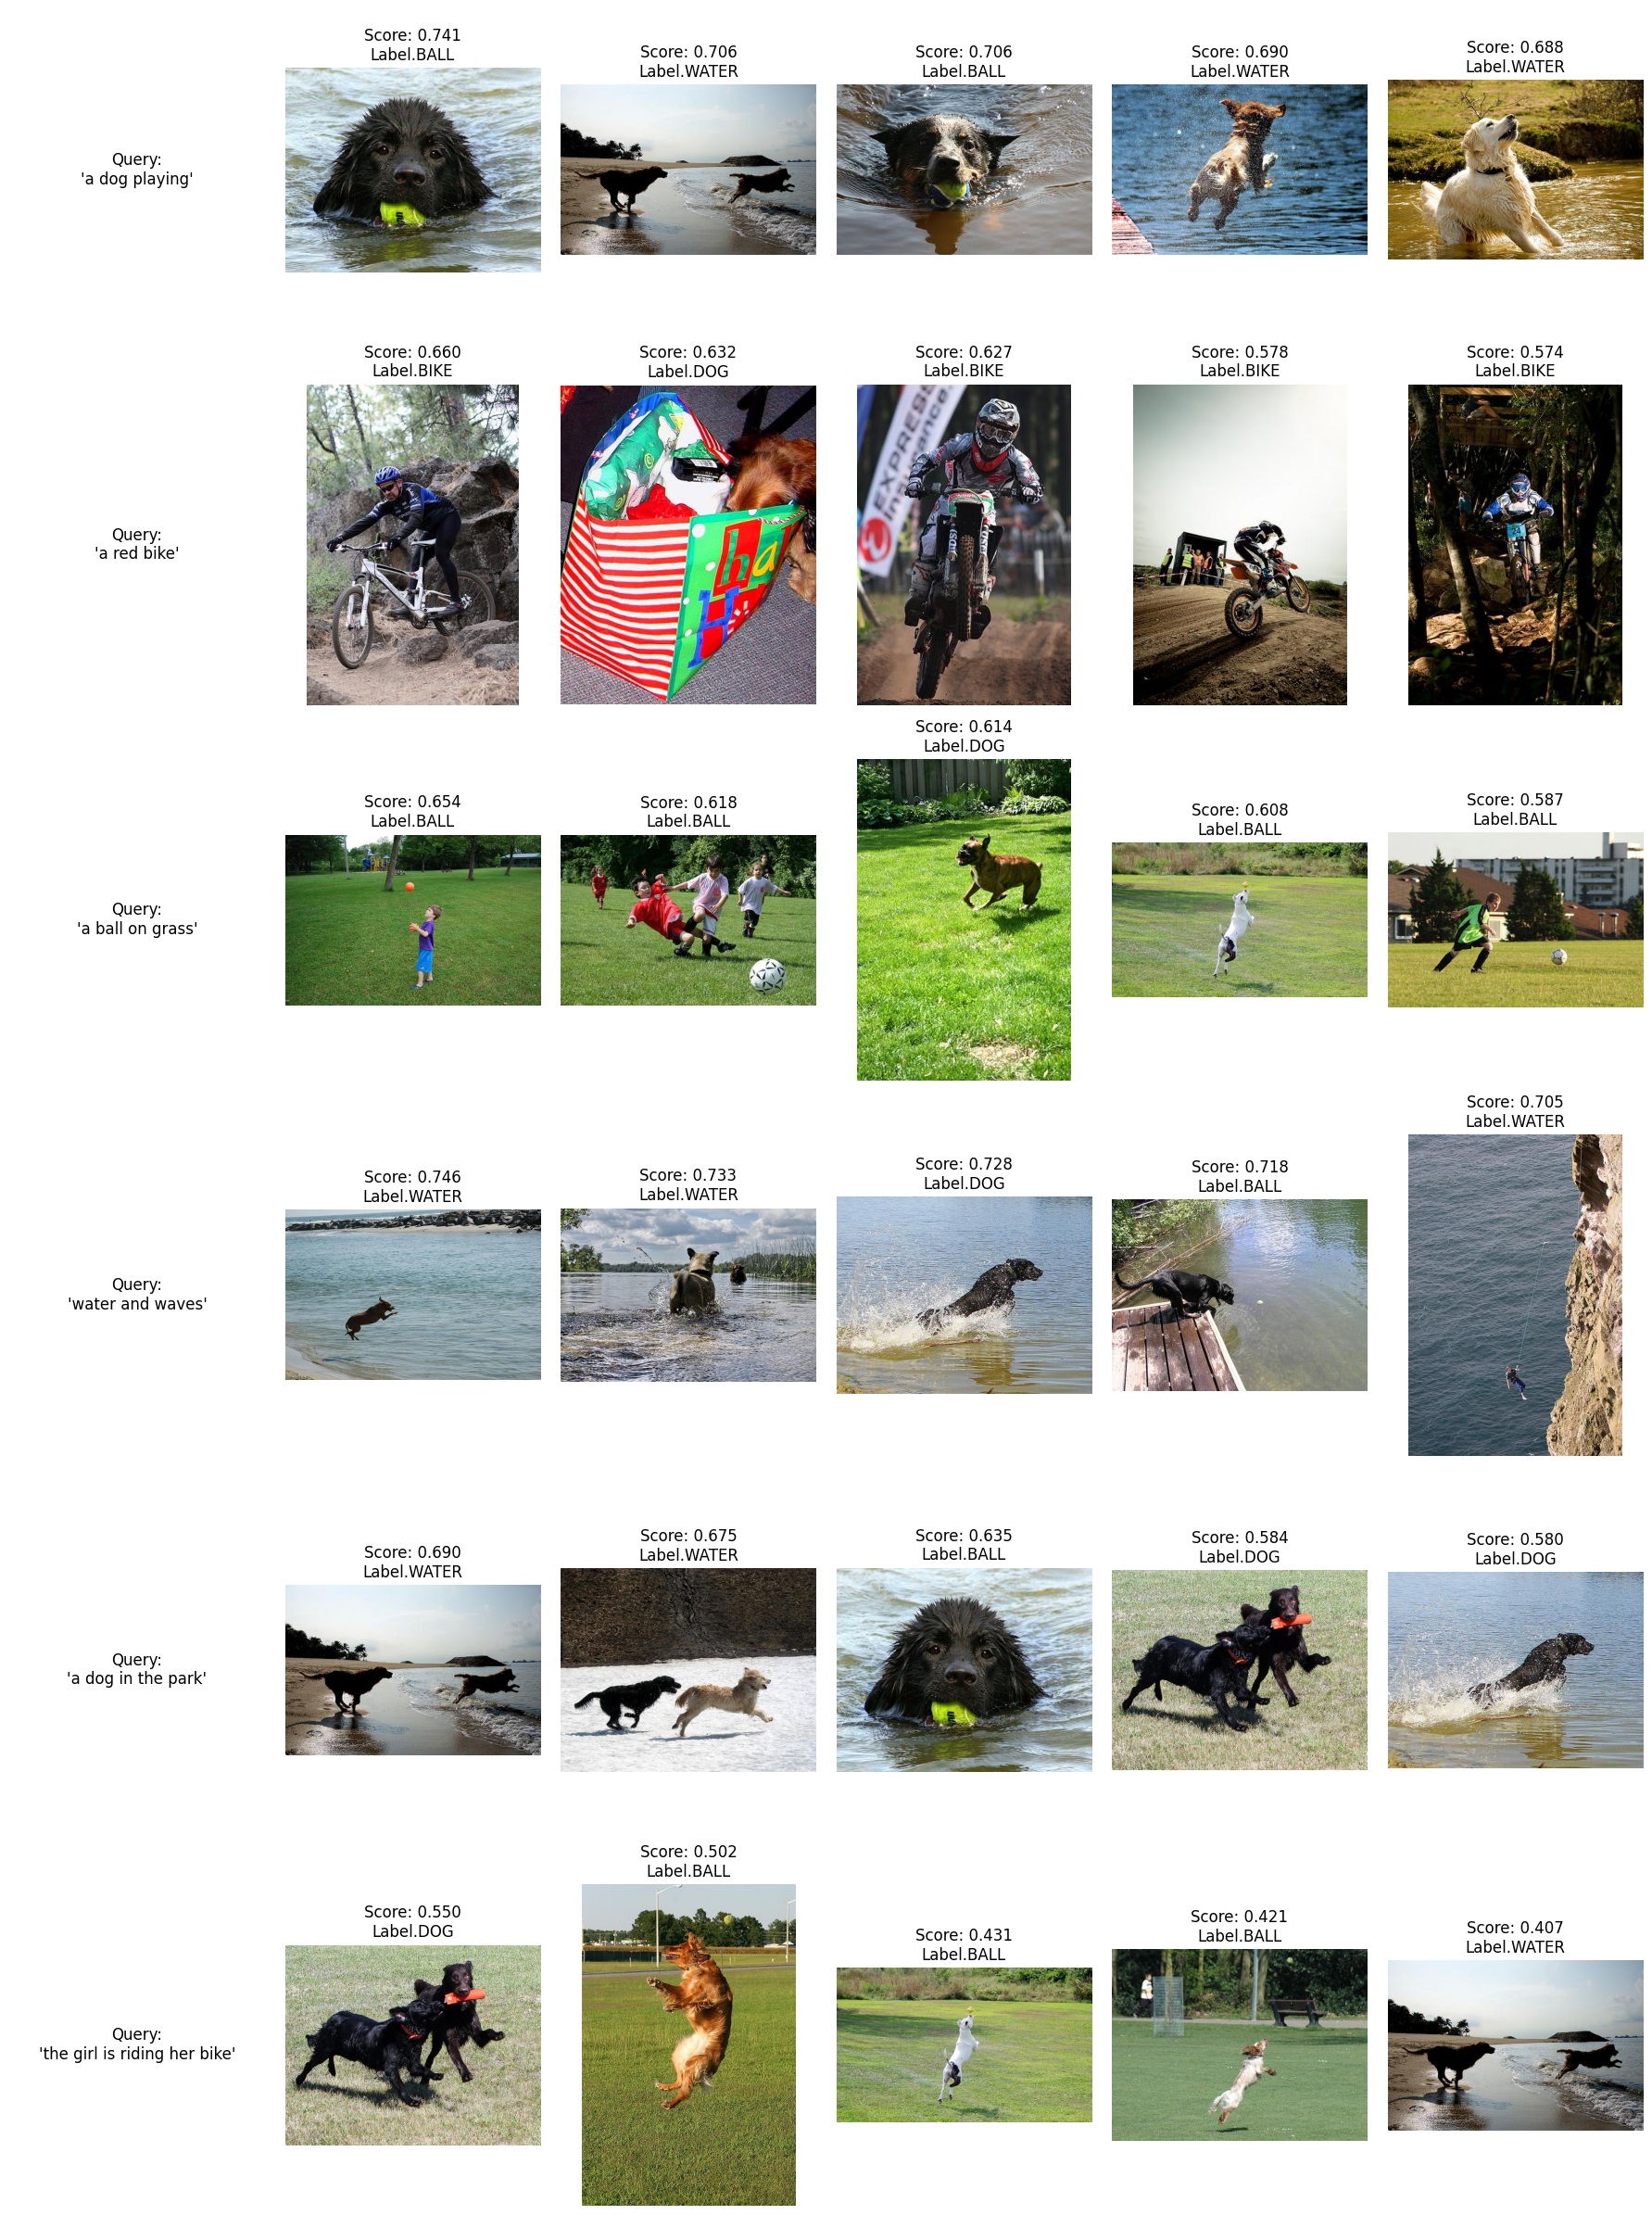

In [27]:
# =============================================================================
# TEST DE RETRIEVAL QUALITATIF
# =============================================================================

@torch.no_grad()
def retrieve_images_from_text(model, text_query, dataset, keras_tokenizer, device, top_k=5):
    """Trouve les images les plus similaires à une requête texte"""
    model.eval()
    
    # Encode la requête
    seq = keras_tokenizer.texts_to_sequences([text_query])[0]
    padded = pad_sequences([seq], maxlen=64, padding="post", truncating="post")[0]
    input_ids = torch.tensor(padded, dtype=torch.long).unsqueeze(0).to(device)
    text_emb = model.encode_text(input_ids)
    
    # Encode toutes les images
    all_img_embs = []
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    for batch in loader:
        images = batch["image"].to(device)
        img_emb = model.encode_image(images)
        all_img_embs.append(img_emb.cpu())
    
    all_img_embs = torch.cat(all_img_embs)
    
    # Calcul similarité
    similarity = (text_emb.cpu() @ all_img_embs.T).squeeze(0)
    top_indices = similarity.argsort(descending=True)[:top_k]
    
    return top_indices.tolist(), similarity[top_indices].tolist()

# Test avec quelques requêtes
queries = ["a dog playing", "a red bike", "a ball on grass", "water and waves", "a dog in the park", "the girl is riding her bike"]

fig, axes = plt.subplots(len(queries), 6, figsize=(18, 4*len(queries)))

for i, query in enumerate(queries):
    indices, scores = retrieve_images_from_text(
       model, query, val_dataset, keras_tokenizer, device, top_k=5
    )
    
    axes[i, 0].text(0.5, 0.5, f"Query:\n'{query}'", ha='center', va='center', fontsize=12)
    axes[i, 0].axis('off')
    
    for j, (idx, score) in enumerate(zip(indices, scores)):
        img_path = val_dataset._get_img_path_from_idx(idx)
        img = Image.open(img_path).convert("RGB")
        axes[i, j+1].imshow(img)
        axes[i, j+1].set_title(f"Score: {score:.3f}\n{val_dataset._get_label_from_idx(idx)}")
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()


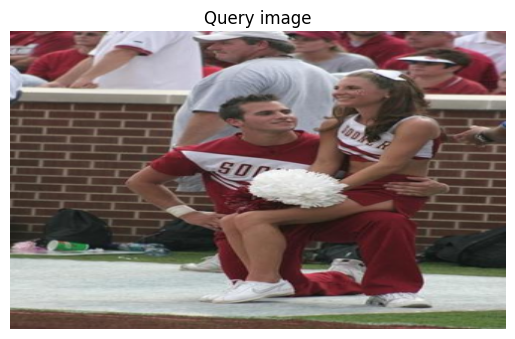


TOP-5 phrases les plus proches :

1. [0.777] The tennis player, her ponytail bouncing behind her, swings her racquet in a smooth arc as she prepares to strike the ball. The ball itself, a yellow sphere with white stitching, sits poised on the edge of the court, awaiting its fate. For a moment, time seems to slow as the player's arm extends and then snaps back, ready to make contact with the ball.
2. [0.762] At a lively high school football game, a boy cheerleader enthusiastically balances on one knee while cradling a large, inflated "Spirit Ball" in his other arm, as he attempts to entice the crowd with some energetic cheers and dance moves. A girl cheerleader, also dressed in matching uniform, sits playfully on his knee, giggling and leaning against him for support. As the boy cheerleader tosses the Spirit Ball into the air, the girl reaches out to catch it, momentarily breaking into a grin as she holds it securely.
3. [0.739] A young boy, clad in athletic wear, enthusiastically swin

In [28]:
# =============================================================================
# RETRIEVAL IMAGE -> TEXT (AFFICHAGE SIMPLE)
# =============================================================================

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

@torch.no_grad()
def retrieve_texts_from_image_simple(
    model,
    image_tensor,      # Tensor (3,H,W)
    dataset,
    device,
    top_k=5,
    batch_size=32
):
    model.eval()

    # 1) Encode image requête
    img = image_tensor.unsqueeze(0).to(device)   # (1,3,H,W)
    img_emb = model.encode_image(img).cpu()      # (1,D)

    # 2) Encode tous les textes du dataset
    all_txt_embs = []
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        txt_emb = model.encode_text(input_ids)
        all_txt_embs.append(txt_emb.cpu())

    all_txt_embs = torch.cat(all_txt_embs, dim=0)  # (N,D)

    # 3) Similarité cosinus
    similarity = (img_emb @ all_txt_embs.T).squeeze(0)  # (N,)
    top_indices = similarity.argsort(descending=True)[:top_k]

    return top_indices.tolist(), similarity[top_indices].tolist()


# Prendre UNE image depuis le val_loader
idx = random.randint(0, len(val_dataset) - 1)
sample = val_dataset[idx]

query_image = sample["image"]

# Retrieval
indices, scores = retrieve_texts_from_image_simple(
    model,
    query_image,
    val_dataset,
    device,
    top_k=5
)

# --- Afficher l'image requête ---
def denormalize_cnn(x):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
    return (x * std + mean).clamp(0,1)

def denormalize_resnet(x):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (x * std + mean).clamp(0,1)

plt.imshow(denormalize_cnn(query_image).permute(1,2,0))
plt.axis("off")
plt.title("Query image")
plt.show()

# --- Print des TOP-5 phrases ---
print("\nTOP-5 phrases les plus proches :\n")

for rank, (idx, score) in enumerate(zip(indices, scores), start=1):
    # Récupération de la phrase
    if hasattr(val_dataset, "_get_caption_from_idx"):
        caption = val_dataset._get_caption_from_idx(idx)
    elif hasattr(val_dataset, "df") and "caption" in val_dataset.df.columns:
        caption = val_dataset.df.iloc[idx]["caption"]
    else:
        caption = f"(caption idx={idx} introuvable)"

    print(f"{rank}. [{score:.3f}] {caption}")
